In [41]:
# -*- coding: utf-8 -*- 
# @Time : 2024/2/5 16:00
# @Author : Ismail Bibers
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented Decision Tree Classifier. 

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl2022_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

In [ ]:
# Take random samples of the dataset
# sample_df_1 = main_df_2.sample(frac=0.6, random_state=42)
sample_df_1 = main_df_2.copy()

In [ ]:
# Extract subsample of data
print (" Extract subsample of data: ")
print(sample_df_1['ALERT'].value_counts())

In [ ]:
# Git the features
# print (main_df_2.head())

In [ ]:
# sample_df_1.info()

In [ ]:
# # To see the features that are need to be encoded "Which are not numerical"
# categorical_columns = sample_df_1.select_dtypes(include=['object']).columns
# print("Categorical Columns:", categorical_columns)

In [ ]:
# # Count the numner of the novsalues in the categorical columns
# print(sample_df_1.isna().sum())

In [ ]:
# # Print the columns with leading spaces, if any
# columns_with_leading_spaces = [col for col in main_df_2.columns if col.startswith(' ')]

# if columns_with_leading_spaces:
#     print("Columns with leading spaces:", columns_with_leading_spaces)
# else:
#     print("No columns with leading spaces found.")

# # Remove leading space character in all feature names
# # main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)


In [ ]:
# sample_df_1 = sample_df_1.drop(['ANOMALY', 'IPV4_SRC_ADDR'] , axis=1)
median_anomaly = sample_df_1['ANOMALY'].median()
sample_df_1['ANOMALY'].fillna(median_anomaly, inplace=True)

In [ ]:
sample_df_1['ALERT'].fillna('Normal', inplace=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['PROTOCOL_MAP', 'IPV4_DST_ADDR', 'IPV4_SRC_ADDR']

# Create a copy of the original DataFrame to avoid modifying the original data
df_encoded = sample_df_1.copy()

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical columns
df_encoded[categorical_columns] = ordinal_encoder.fit_transform(sample_df_1[categorical_columns])

In [ ]:
# # Fill nan values
# print(sample_df_1.isna().sum())

In [ ]:
print("Sampled Dataset Overview:")

dropped_df = ['ALERT']
X = df_encoded.drop(dropped_df, axis=1)
y = df_encoded['ALERT']

In [ ]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the models
rf_model = RandomForestClassifier()
nn_model = MLPClassifier()
lr_model = LogisticRegression()
dst_model = DecisionTreeClassifier()

# Print the number of samples before training
print("Number of samples before training:", len(X_train))

In [ ]:
# Train the models
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
dst_model.fit(X_train, y_train)

In [ ]:
# Make predictions models
rf_pred = rf_model.predict(X_test)
nn_pred = nn_model.predict(X_test)
lr_pred = lr_model.predict(X_test)
dst_pred = dst_model.predict(X_test)

In [ ]:
# Create a meta-model (e.g., Logistic Regression)
meta_model = DecisionTreeClassifier()
# meta_model = LogisticRegression()
# meta_model = MLPClassifier()
# meta_model = RandomForestClassifier()

In [ ]:
# Stack models using StackingClassifier
stacked_model = StackingClassifier(estimators=[
    ('rf', rf_model),
    ('nn', nn_model),
    ('lr', lr_model),
    ('dst', dst_model),
    # ('svm', svm_model)
], final_estimator=meta_model)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions with the stacked model
stacked_pred__encoded = stacked_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, stacked_pred__encoded)
print(f"Accuracy: {accuracy}")

In [ ]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, stacked_pred__encoded))

In [ ]:
import numpy as np
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, stacked_pred__encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, stacked_pred__encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Extract feature importances from base models
base_models_importances = {}

for name, model in stacked_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        base_models_importances[name] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(14, 20))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in StackingClassifier')
plt.show()

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_data.csv')

tf.keras.backend.clear_session()

In [6]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Convert data to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(pd.factorize(y_train)[0], dtype=tf.int64)
X_test_tf = tf.convert_to_tensor(X_test.values, dtype=tf.float32)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# the base models
rf_model = RandomForestClassifier()
nn_model = MLPClassifier()
lr_model = LogisticRegression()
dst_model = DecisionTreeClassifier()

# Train the models
with strategy.scope():
    # Train the models
    rf_model.fit(X_train, y_train)
    nn_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)
    dst_model.fit(X_train, y_train)

    # Make predictions models
    rf_pred = rf_model.predict(X_test)
    nn_pred = nn_model.predict(X_test)
    lr_pred = lr_model.predict(X_test)
    dst_pred = dst_model.predict(X_test)

    meta_model = DecisionTreeClassifier()
    
    from sklearn.ensemble import StackingClassifier
    # Stack models using StackingClassifier
    stacked_model = StackingClassifier(estimators=[
        ('rf', rf_model),
        ('nn', nn_model),
        ('lr', lr_model),
        ('dst', dst_model),
        # ('svm', svm_model)
    ], final_estimator=meta_model)

    # Train the stacked model
    stacked_model.fit(X_train, y_train)

    # Make predictions with the stacked model
    stacked_pred__encoded = stacked_model.predict(X_test)

# # Convert probabilities to TensorFlow tensors
# pred_tf = tf.convert_to_tensor(y_pred_enc, dtype=tf.float32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, stacked_pred__encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [9]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(stacked_pred__encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    497905
          Malware       1.00      1.00      1.00       114
    Port Scanning       1.00      1.00      1.00    151442

         accuracy                           1.00    649461
        macro avg       1.00      1.00      1.00    649461
     weighted avg       1.00      1.00      1.00    649461



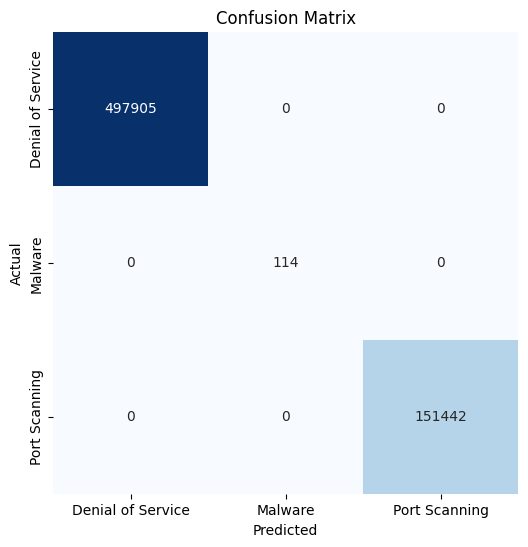

In [10]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1719234/548402338.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


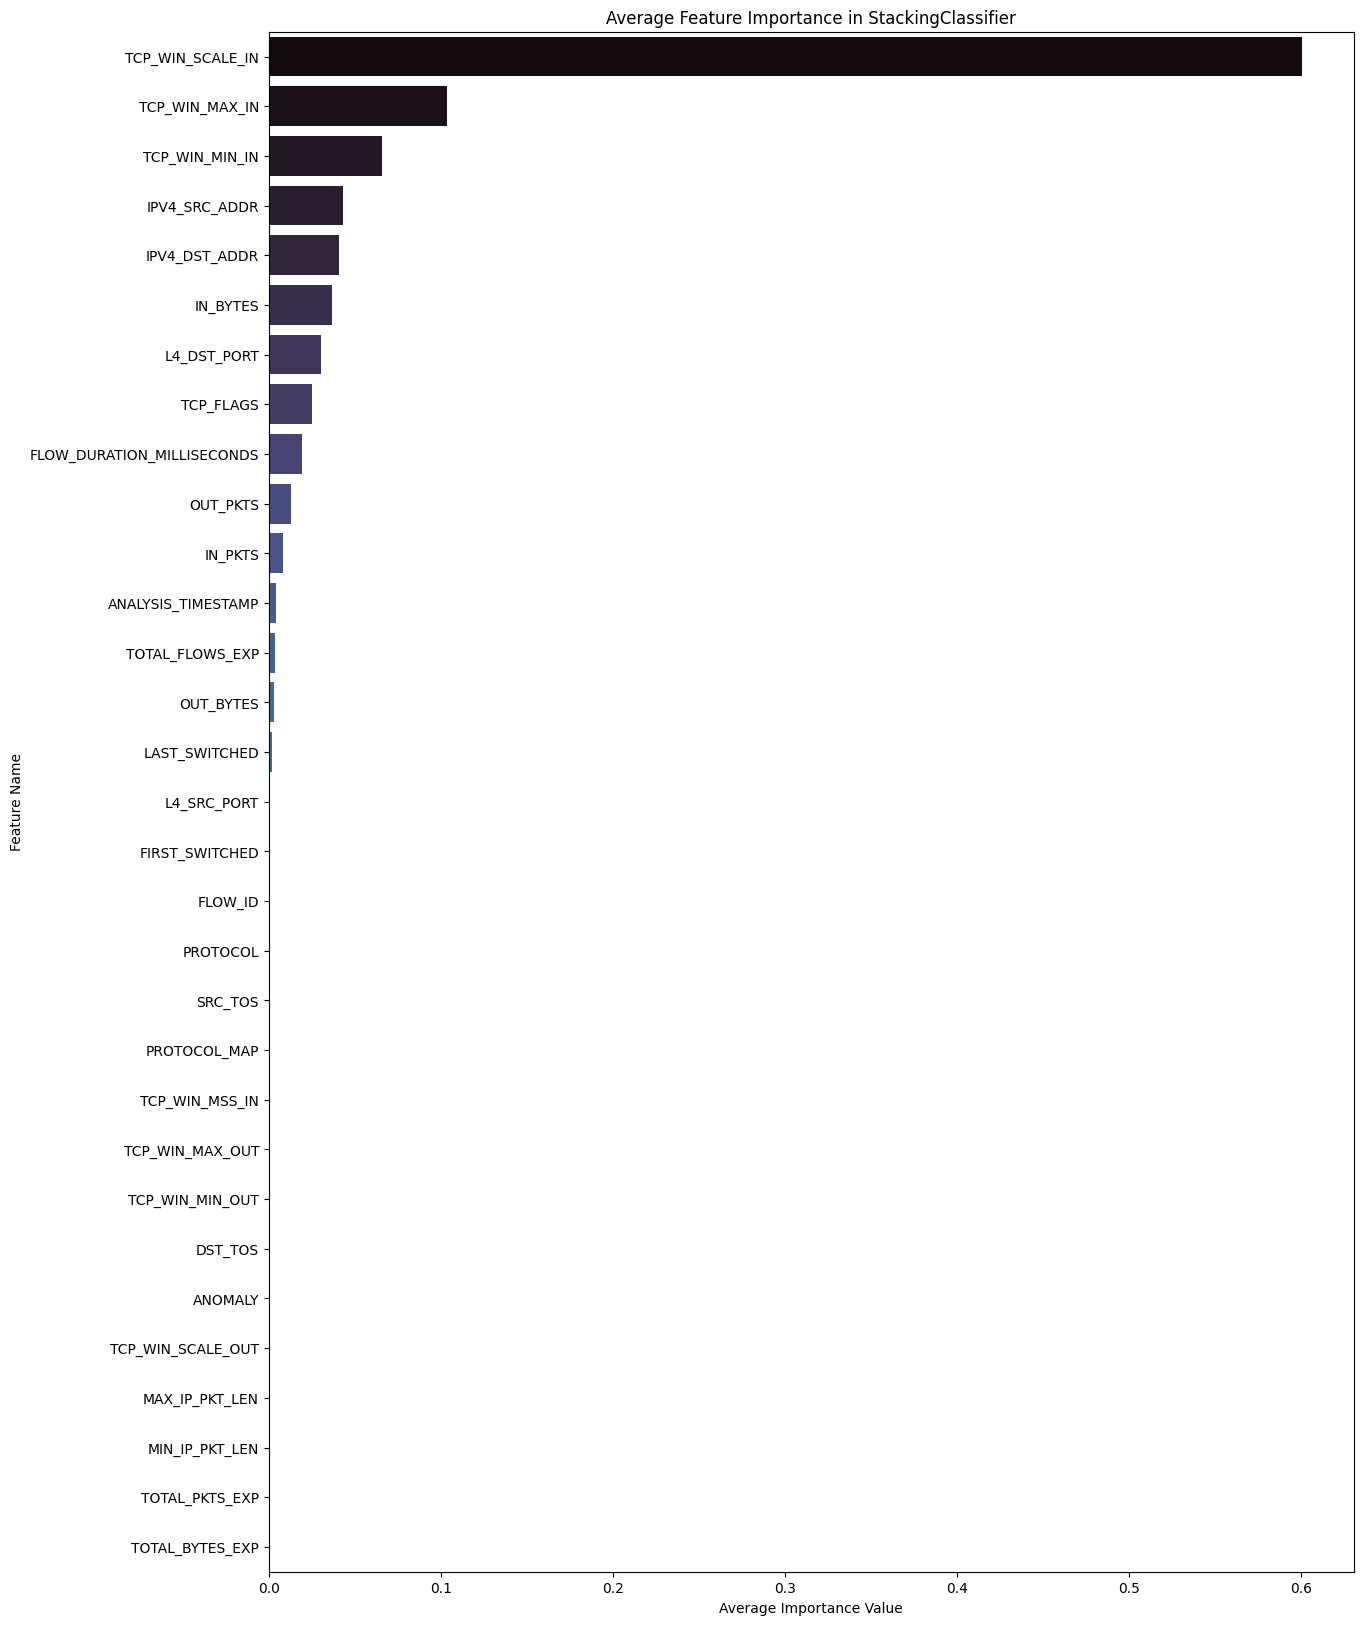

In [11]:
# Extract feature importances from base models
base_models_importances = {}

for name, model in stacked_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        base_models_importances[name] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(14, 20))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in StackingClassifier')
plt.show()